In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from tqdm import tqdm
import os
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numpy import linalg as la
from numpy import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_edmd_torch_gpu_sde import KoopmanNNTorch, KoopmanSolverTorch
from solver_gedmd_torch_gpu import KoopmanNNTorch as KoopmanNNTorch_g
from solver_gedmd_torch_gpu import  KoopmanSolverTorch as KoopmanSolverTorch_g
print (torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)
print (torch.cuda.get_device_name())
# device= 'cpu'
device= 'cuda'

2.3.1 True
11.8
NVIDIA GeForce RTX 3070 Ti


In [2]:
import torch
torch.cuda.empty_cache()


In [3]:
## Define the potential function V(x, y) and plot the potential landscape
def potential(x, y):
    return (
        3 * np.exp(-x**2 - (y - 1/3)**2)
        - 3 * np.exp(-x**2 - (y - 5/3)**2)
        - 5 * np.exp(-(x - 1)**2 - y**2)
        - 5 * np.exp(-(x + 1)**2 - y**2)
        + 0.2 * x**4
        + 0.2 * (y - 1/3)**4
    )

# Define the gradient of the potential function
def gradient(x, y):
    dVdx = (
        -6 * x * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * x * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * (x - 1) * np.exp(-(x - 1)**2 - y**2)
        + 10 * (x + 1) * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * x**3
    )
    dVdy = (
        -6 * (y - 1/3) * np.exp(-x**2 - (y - 1/3)**2)
        + 6 * (y - 5/3) * np.exp(-x**2 - (y - 5/3)**2)
        + 10 * y * np.exp(-(x - 1)**2 - y**2)
        + 10 * y * np.exp(-(x + 1)**2 - y**2)
        + 0.8 * (y - 1/3)**3
    )
    return dVdx, dVdy

## Generate m^2 trajectories in the landscape
# Set the parameters for the SDE
#h = 1e-3  # Integration step size
h = 1e-5  # Integration step size
#h = 1e-5  # Integration step size
n_steps = 100  # Number of integration steps between each evaluation
n_eval = 10  # Number of evaluations
lag_time = h * n_steps  # Lag time

# Set the number of points to select in each dimension
m = 12

# Set the diffusion coefficient
sigma = 1.09
print ('Lag time: ', lag_time)

Lag time:  0.001


In [4]:
# Generate linspace for x and y coordinates
x_values = np.linspace(-2, 2, m)
y_values = np.linspace(-1, 2, m)

# Create a meshgrid from these linspace arrays
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid matrices to get the coordinate pairs
x0_values = xx.flatten()
y0_values = yy.flatten()

# Initialize the data_matrix
data_matrix = np.zeros((m**2, n_eval+1, 2))

# Generate trajectories for each selected point
for i in tqdm (range(m**2)):
    x = x0_values[i]
    y = y0_values[i]
    
    for j in range(n_eval+1):
        data_matrix[i, j, 0] = x
        data_matrix[i, j, 1] = y
        
        for k in range(n_steps):
            dVdx, dVdy = gradient(x, y)
            x += -dVdx * h + sigma * np.sqrt(h) * np.random.normal()
            y += -dVdy * h + sigma * np.sqrt(h) * np.random.normal()

# Create a grid of points
x_plot = np.linspace(-2, 2, 100)
y_plot = np.linspace(-1, 2, 100)
X, Y = np.meshgrid(x_plot, y_plot)

  0%|          | 0/144 [00:00<?, ?it/s]

100%|██████████| 144/144 [00:02<00:00, 71.91it/s]


In [5]:
# ## Save the data to local folder
# # Create a folder to store the data (if it doesn't exist)
# folder_path = "data"
# os.makedirs(folder_path, exist_ok=True)

# # Save the data_matrix to a file
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# np.save(file_path, data_matrix)

In [6]:
# ## load the data from local folder
# import os
# # Load the data_matrix from the file
# folder_path = "data"
# file_path = os.path.join(folder_path, f"triple_well_2d_{lag_time}.npy")
# data_matrix = np.load(file_path)
# data_matrix.shape

In [7]:
!nvidia-smi

Mon Dec  9 12:03:57 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
| 37%   54C    P0             79W /  290W |    3516MiB /   8192MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Extract data_X and data_Y from the data matrix
data_X = data_matrix[:, :-1, :]
data_Y = data_matrix[:, 1:, :]
print(f"Shape of data_X: {data_X.shape}")
print(f"Shape of data_Y: {data_Y.shape}")

# Reshape data_X and data_Y into a single column
X = data_X.reshape(-1, data_X.shape[2])  # 2D features
Y = data_Y.reshape(-1, data_X.shape[2])  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)

Shape of data_X: (144, 10, 2)
Shape of data_Y: (144, 10, 2)
Shape of X: (1440, 2)
Shape of Y: (1440, 2)
(1007, 2)


In [9]:


checkpoint_file= 'well2d_example_ckpt004.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= lag_time)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues = solver.eigenvalues.T
efuns = solver.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver.get_Psi_X()
Psi_Y = solver.get_Psi_Y()
Koopman_matrix_K = solver.K

outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Epoch: 1 	Training Loss: 1.646080 val loss: 1.762243
saving, val loss enhanced: 1.7622431351059527 10000
Epoch: 2 	Training Loss: 1.632236 val loss: 1.728305
saving, val loss enhanced: 1.7283045073709247 1.7622431351059527
Epoch: 3 	Training Loss: 1.610773 val loss: 1.732789
Epoch: 4 	Training Loss: 1.596657 val loss: 1.707899
saving, val loss enhanced: 1.7078993070256474 1.7283045073709247
Epoch: 5 	Training Loss: 1.584031 val loss: 1.703436
saving, val loss enhanced: 1.703435585404758 1.7078993070256474
Epoch: 6 	Training Loss: 1.569763 val loss: 1.675864
saving, val loss enhanced: 1.6758635843208072 1.703435585404758
Epoch: 7 	Training Loss: 1.544445 val loss: 1.646074
saving, val loss enhanced: 1.646073530661706 1.6758635843208072
Epoch: 8 	Training Loss: 1.538382 val loss: 1.659792
Epoch: 9 	Training Loss: 1.525220 val loss: 1.625397
saving, val loss enhanced: 1.6253973798904544 1.646073530661706
Epoch: 10 	Training Loss: 1.508799 val loss: 1.609365
saving, val loss enhanced: 1.60

Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4306.38iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
saving FNN a and b to:  a_b_example_3ple_well.jbl
Outer Epoch 1/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4130.70iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002702616955970778 1000000000000000.0
Epoch: 2 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.00027022690943049986 0.0002702616955970778
Epoch: 3 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.00027019217331646507 0.00027022690943049986
Epoch: 4 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.00027015747407829787 0.00027019217331646507
Epoch 1 time: 4.37 seconds
Outer Epoch 2/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4200.81iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002701212261441291 0.00027015747407829787
Epoch: 2 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.00027008659500488803 0.0002701212261441291
Epoch: 3 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002700519968944708 0.00027008659500488803
Epoch: 4 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002700174320296559 0.0002700519968944708
Epoch 2 time: 4.28 seconds
Outer Epoch 3/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3943.02iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.00026998139438382066 0.0002700174320296559
Epoch: 2 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.00026994689813463396 0.00026998139438382066
Epoch: 3 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002699124359021912 0.00026994689813463396
Epoch: 4 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002698780078212293 0.0002699124359021912
Epoch 3 time: 4.49 seconds
Outer Epoch 4/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 3866.25iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.00026984213197255366 0.0002698780078212293
Epoch: 2 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002698077737511935 0.00026984213197255366
Epoch: 3 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.00026977344989821054 0.0002698077737511935
Epoch: 4 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002697391603951573 0.00026977344989821054
Epoch 4 time: 4.71 seconds
Outer Epoch 5/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4108.66iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002697034156540454 0.0002697391603951573
Epoch: 2 	Training Loss: 0.000295 val loss: 0.000270
saving, val loss enhanced: 0.0002696691960706533 0.0002697034156540454
Epoch: 3 	Training Loss: 0.000294 val loss: 0.000270
saving, val loss enhanced: 0.0002696350107726915 0.0002696691960706533
Epoch: 4 	Training Loss: 0.000294 val loss: 0.000270
saving, val loss enhanced: 0.00026960085969052015 0.0002696350107726915
Epoch 5 time: 4.48 seconds
Outer Epoch 6/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4165.46iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000294 val loss: 0.000270
saving, val loss enhanced: 0.00026956530681211953 0.00026960085969052015
Epoch: 2 	Training Loss: 0.000294 val loss: 0.000270
saving, val loss enhanced: 0.00026953122524176056 0.00026956530681211953
Epoch: 3 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.00026949717774433704 0.00026953122524176056
Epoch: 4 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.0002694631642391331 0.00026949717774433704
Epoch 6 time: 4.34 seconds
Outer Epoch 7/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4328.21iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.0002694277943921513 0.0002694631642391331
Epoch: 2 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.0002693938499063493 0.0002694277943921513
Epoch: 3 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.0002693599392567317 0.0002693938499063493
Epoch: 4 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.00026932606236182926 0.0002693599392567317
Epoch 7 time: 4.24 seconds
Outer Epoch 8/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4127.60iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.00026929084865896634 0.00026932606236182926
Epoch: 2 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.0002692570402913829 0.00026929084865896634
Epoch: 3 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.00026922326552416046 0.0002692570402913829
Epoch: 4 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.0002691895242770138 0.00026922326552416046
Epoch 8 time: 4.35 seconds
Outer Epoch 9/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4292.43iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.0002691544840287463 0.0002691895242770138
Epoch: 2 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.00026912081081335154 0.0002691544840287463
Epoch: 3 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.00026908717096714766 0.00026912081081335154
Epoch: 4 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.00026905356441127477 0.00026908717096714766
Epoch 9 time: 4.25 seconds
Outer Epoch 10/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4351.66iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000294 val loss: 0.000269
saving, val loss enhanced: 0.00026901866142796117 0.00026905356441127477
Epoch: 2 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.0002689851224361248 0.00026901866142796117
Epoch: 3 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.0002689516165868424 0.0002689851224361248
Epoch: 4 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.0002689181438026225 0.0002689516165868424
Epoch 10 time: 4.21 seconds
Outer Epoch 11/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4192.11iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.00026888344153073703 0.0002689181438026225
Epoch: 2 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.0002688500358172899 0.00026888344153073703
Epoch: 3 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.00026881666302418195 0.0002688500358172899
Epoch: 4 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.0002687833230750052 0.00026881666302418195
Epoch 11 time: 4.33 seconds
Outer Epoch 12/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4387.38iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.00026874878733958824 0.0002687833230750052
Epoch: 2 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.00026871551400129356 0.00026874878733958824
Epoch: 3 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.0002686822733626337 0.00026871551400129356
Epoch: 4 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.0002686490653489674 0.0002686822733626337
Epoch 12 time: 4.20 seconds
Outer Epoch 13/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4206.99iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.00026861466478018205 0.0002686490653489674
Epoch: 2 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.00026858152292932755 0.00026861466478018205
Epoch: 3 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.00026854841356346485 0.00026858152292932755
Epoch: 4 	Training Loss: 0.000293 val loss: 0.000269
saving, val loss enhanced: 0.00026851533660858355 0.00026854841356346485
Epoch 13 time: 4.30 seconds
Outer Epoch 14/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4319.24iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000293 val loss: 0.000268
saving, val loss enhanced: 0.00026848109296722836 0.00026851533660858355
Epoch: 2 	Training Loss: 0.000293 val loss: 0.000268
saving, val loss enhanced: 0.0002684480817275371 0.00026848109296722836
Epoch: 3 	Training Loss: 0.000293 val loss: 0.000268
saving, val loss enhanced: 0.00026841510275942866 0.0002684480817275371
Epoch: 4 	Training Loss: 0.000293 val loss: 0.000268
saving, val loss enhanced: 0.0002683821559900767 0.00026841510275942866
Epoch 14 time: 4.25 seconds
Outer Epoch 15/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4272.48iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000292 val loss: 0.000268
saving, val loss enhanced: 0.00026834807702243516 0.0002683821559900767
Epoch: 2 	Training Loss: 0.000292 val loss: 0.000268
saving, val loss enhanced: 0.0002683151955136836 0.00026834807702243516
Epoch: 3 	Training Loss: 0.000292 val loss: 0.000268
saving, val loss enhanced: 0.0002682823460663779 0.0002683151955136836
Epoch: 4 	Training Loss: 0.000292 val loss: 0.000268
saving, val loss enhanced: 0.00026824952860865357 0.0002682823460663779
Epoch 15 time: 4.32 seconds
Outer Epoch 16/16


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4302.07iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Epoch: 1 	Training Loss: 0.000292 val loss: 0.000268
saving, val loss enhanced: 0.0002682155881095312 0.00026824952860865357
Epoch: 2 	Training Loss: 0.000292 val loss: 0.000268
saving, val loss enhanced: 0.0002681828354850036 0.0002682155881095312
Epoch: 3 	Training Loss: 0.000292 val loss: 0.000268
saving, val loss enhanced: 0.00026815011471438647 0.0002681828354850036
Epoch: 4 	Training Loss: 0.000292 val loss: 0.000268
saving, val loss enhanced: 0.000268117425726751 0.00026815011471438647
Epoch 16 time: 4.23 seconds


In [10]:
print (solver.L_Psi.shape, solver.dPsi_X.shape, solver.data_x_train[:-1, :].shape, solver.data_y_train.shape, solver.Psi_X.shape)

torch.Size([10, 10]) torch.Size([1006, 10]) (1006, 2) (1007, 2) torch.Size([1007, 10])


(10,)
[9.99991425e-01 9.98340088e-01 9.96536422e-01 9.74631449e-01
 9.71163478e-01 8.15164895e-01 5.54580771e-01 6.20343385e-02
 1.62588480e-02 2.06242490e-04]


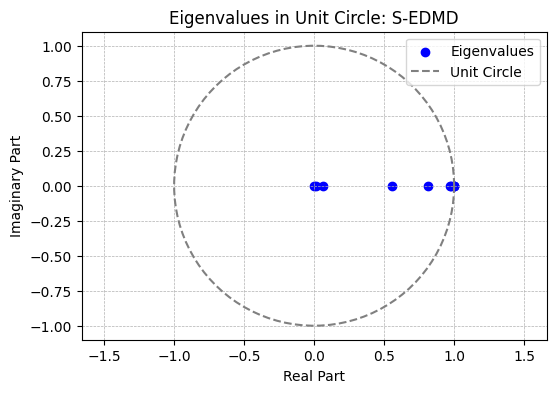

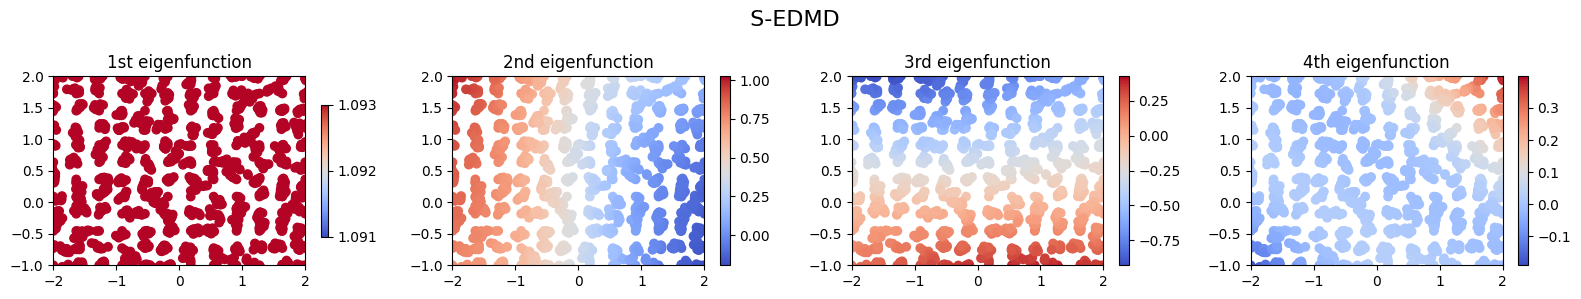

In [11]:
# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues is a numpy array of complex numbers
print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: S-EDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' S-EDMD ', fontsize=16)
plt.tight_layout()
plt.show()


In [12]:
checkpoint_file_g= 'well2d_example_ckpt004_g.torch'

basis_function_g = KoopmanNNTorch(input_size= 2, layer_sizes=[10], n_psi_train=7).to(device)  # basis number would be 20


solver_g = KoopmanSolverTorch_g(dic=basis_function_g, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file_g, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_3ple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32)

solver_g.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=16,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_gedmd
evalues = solver_g.eigenvalues.T
efuns = solver_g.eigenfunctions(X)
#kpm_modes = solver.compute_mode().T
N_dict = np.shape(evalues)[0]
Psi_X = solver_g.get_Psi_X()
Psi_Y = solver_g.get_Psi_Y()


outputs = {
    'efuns': efuns,
    'evalues': evalues,
#    'kpm_modes': kpm_modes,
    'N_dict': N_dict,
#    'K': Koopman_matrix_K,
    'Psi_X': Psi_X,
    'Psi_Y': Psi_Y,
    }



Precomputed SDE coefficients loaded from: a_b_example_3ple_well.jbl
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4681.03iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
Outer Epoch 1/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4651.58iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4629.88iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4604.38iteration/s]


Epoch: 1 	Training Loss: 275.197257 val loss: 633.107189
saving, val loss enhanced: 633.1071888231016 1000000000000000.0
Epoch: 2 	Training Loss: 274.890786 val loss: 632.614719
saving, val loss enhanced: 632.6147194570608 633.1071888231016
Epoch: 3 	Training Loss: 274.589780 val loss: 632.115765
saving, val loss enhanced: 632.1157651511515 632.6147194570608
Epoch: 4 	Training Loss: 274.289471 val loss: 631.614653
saving, val loss enhanced: 631.6146528182663 632.1157651511515
Epoch 1 time: 9.66 seconds
Outer Epoch 2/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4705.75iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4678.83iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4743.91iteration/s]


Epoch: 1 	Training Loss: 273.001971 val loss: 628.514253
saving, val loss enhanced: 628.5142525426771 631.6146528182663
Epoch: 2 	Training Loss: 272.703984 val loss: 628.015039
saving, val loss enhanced: 628.0150390562461 628.5142525426771
Epoch: 3 	Training Loss: 272.406490 val loss: 627.516107
saving, val loss enhanced: 627.5161073760096 628.0150390562461
Epoch: 4 	Training Loss: 272.109421 val loss: 627.017540
saving, val loss enhanced: 627.0175397716218 627.5161073760096
Epoch 2 time: 9.61 seconds
Outer Epoch 3/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4663.95iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4821.14iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4632.21iteration/s]


Epoch: 1 	Training Loss: 270.835522 val loss: 623.954343
saving, val loss enhanced: 623.9543425457827 627.0175397716218
Epoch: 2 	Training Loss: 270.540756 val loss: 623.459580
saving, val loss enhanced: 623.4595801063887 623.9543425457827
Epoch: 3 	Training Loss: 270.246517 val loss: 622.965486
saving, val loss enhanced: 622.9654857847507 623.4595801063887
Epoch: 4 	Training Loss: 269.952713 val loss: 622.471959
saving, val loss enhanced: 622.4719594072325 622.9654857847507
Epoch 3 time: 9.65 seconds
Outer Epoch 4/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4844.80iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4501.58iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4796.46iteration/s]


Epoch: 1 	Training Loss: 268.694580 val loss: 619.441333
saving, val loss enhanced: 619.4413334301051 622.4719594072325
Epoch: 2 	Training Loss: 268.403061 val loss: 618.951776
saving, val loss enhanced: 618.9517755993229 619.4413334301051
Epoch: 3 	Training Loss: 268.112065 val loss: 618.462911
saving, val loss enhanced: 618.4629114991964 618.9517755993229
Epoch: 4 	Training Loss: 267.821493 val loss: 617.974609
saving, val loss enhanced: 617.9746090573357 618.4629114991964
Epoch 4 time: 9.66 seconds
Outer Epoch 5/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4551.22iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4810.08iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4927.20iteration/s]


Epoch: 1 	Training Loss: 266.579260 val loss: 614.976391
saving, val loss enhanced: 614.976390754421 617.9746090573357
Epoch: 2 	Training Loss: 266.290926 val loss: 614.491999
saving, val loss enhanced: 614.4919988662499 614.976390754421
Epoch: 3 	Training Loss: 266.003104 val loss: 614.008277
saving, val loss enhanced: 614.008277091508 614.4919988662499
Epoch: 4 	Training Loss: 265.715690 val loss: 613.525087
saving, val loss enhanced: 613.5250866154387 614.008277091508
Epoch 5 time: 9.72 seconds
Outer Epoch 6/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4676.57iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4928.47iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4911.22iteration/s]


Epoch: 1 	Training Loss: 264.488998 val loss: 610.558459
saving, val loss enhanced: 610.5584590660565 613.5250866154387
Epoch: 2 	Training Loss: 264.203773 val loss: 610.079097
saving, val loss enhanced: 610.079097237292 610.5584590660565
Epoch: 3 	Training Loss: 263.919047 val loss: 609.600380
saving, val loss enhanced: 609.6003804843209 610.079097237292
Epoch: 4 	Training Loss: 263.634717 val loss: 609.122169
saving, val loss enhanced: 609.1221685519091 609.6003804843209
Epoch 6 time: 9.46 seconds
Outer Epoch 7/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4872.01iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4724.81iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4992.96iteration/s]


Epoch: 1 	Training Loss: 262.423146 val loss: 606.186320
saving, val loss enhanced: 606.1863200320191 609.1221685519091
Epoch: 2 	Training Loss: 262.140961 val loss: 605.711861
saving, val loss enhanced: 605.7118614159324 606.1863200320191
Epoch: 3 	Training Loss: 261.859264 val loss: 605.238027
saving, val loss enhanced: 605.2380273515662 605.7118614159324
Epoch: 4 	Training Loss: 261.577952 val loss: 604.764677
saving, val loss enhanced: 604.7646774379366 605.2380273515662
Epoch 7 time: 9.43 seconds
Outer Epoch 8/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4681.55iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4876.57iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4785.37iteration/s]


Epoch: 1 	Training Loss: 260.381109 val loss: 601.858915
saving, val loss enhanced: 601.8589146329059 604.7646774379366
Epoch: 2 	Training Loss: 260.101903 val loss: 601.389251
saving, val loss enhanced: 601.389250840745 601.8589146329059
Epoch: 3 	Training Loss: 259.823175 val loss: 600.920195
saving, val loss enhanced: 600.9201948027824 601.389250840745
Epoch: 4 	Training Loss: 259.544822 val loss: 600.451606
saving, val loss enhanced: 600.4516064349696 600.9201948027824
Epoch 8 time: 9.59 seconds
Outer Epoch 9/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4718.02iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4904.77iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4842.85iteration/s]


Epoch: 1 	Training Loss: 258.362354 val loss: 597.575335
saving, val loss enhanced: 597.5753353849066 600.4516064349696
Epoch: 2 	Training Loss: 258.086070 val loss: 597.110372
saving, val loss enhanced: 597.1103719041323 597.5753353849066
Epoch: 3 	Training Loss: 257.810256 val loss: 596.646002
saving, val loss enhanced: 596.6460018787471 597.1103719041323
Epoch: 4 	Training Loss: 257.534810 val loss: 596.182086
saving, val loss enhanced: 596.1820858065507 596.6460018787471
Epoch 9 time: 9.56 seconds
Outer Epoch 10/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4651.88iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4700.22iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4793.69iteration/s]


Epoch: 1 	Training Loss: 256.366389 val loss: 593.334780
saving, val loss enhanced: 593.3347804909657 596.1820858065507
Epoch: 2 	Training Loss: 256.092977 val loss: 592.874432
saving, val loss enhanced: 592.874432230626 593.3347804909657
Epoch: 3 	Training Loss: 255.820027 val loss: 592.414665
saving, val loss enhanced: 592.4146647848866 592.874432230626
Epoch: 4 	Training Loss: 255.547437 val loss: 591.955339
saving, val loss enhanced: 591.9553394246319 592.4146647848866
Epoch 10 time: 9.73 seconds
Outer Epoch 11/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4812.86iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4886.40iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4837.39iteration/s]


Epoch: 1 	Training Loss: 254.392758 val loss: 589.136519
saving, val loss enhanced: 589.1365194791612 591.9553394246319
Epoch: 2 	Training Loss: 254.122170 val loss: 588.680708
saving, val loss enhanced: 588.6807078720595 589.1365194791612
Epoch: 3 	Training Loss: 253.852036 val loss: 588.225466
saving, val loss enhanced: 588.2254655816718 588.6807078720595
Epoch: 4 	Training Loss: 253.582255 val loss: 587.770655
saving, val loss enhanced: 587.7706547975805 588.2254655816718
Epoch 11 time: 9.68 seconds
Outer Epoch 12/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4663.31iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4831.46iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4710.30iteration/s]


Epoch: 1 	Training Loss: 252.441030 val loss: 584.979872
saving, val loss enhanced: 584.979871935537 587.7706547975805
Epoch: 2 	Training Loss: 252.173220 val loss: 584.528523
saving, val loss enhanced: 584.5285231605037 584.979871935537
Epoch: 3 	Training Loss: 251.905856 val loss: 584.077733
saving, val loss enhanced: 584.0777330314864 584.5285231605037
Epoch: 4 	Training Loss: 251.638839 val loss: 583.627365
saving, val loss enhanced: 583.6273647677681 584.0777330314864
Epoch 12 time: 9.62 seconds
Outer Epoch 13/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4971.43iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4817.59iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4479.90iteration/s]


Epoch: 1 	Training Loss: 250.510794 val loss: 580.864194
saving, val loss enhanced: 580.864194470725 583.6273647677681
Epoch: 2 	Training Loss: 250.245718 val loss: 580.417238
saving, val loss enhanced: 580.4172383441747 580.864194470725
Epoch: 3 	Training Loss: 249.981082 val loss: 579.970831
saving, val loss enhanced: 579.9708308204715 580.4172383441747
Epoch: 4 	Training Loss: 249.716785 val loss: 579.524836
saving, val loss enhanced: 579.5248362324537 579.9708308204715
Epoch 13 time: 9.60 seconds
Outer Epoch 14/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4732.31iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4944.91iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4914.97iteration/s]


Epoch: 1 	Training Loss: 248.601657 val loss: 576.788872
saving, val loss enhanced: 576.7888724492617 579.5248362324537
Epoch: 2 	Training Loss: 248.339273 val loss: 576.346242
saving, val loss enhanced: 576.3462417077532 576.7888724492617
Epoch: 3 	Training Loss: 248.077321 val loss: 575.904150
saving, val loss enhanced: 575.904150022228 576.3462417077532
Epoch: 4 	Training Loss: 247.815704 val loss: 575.462463
saving, val loss enhanced: 575.4624629016977 575.904150022228
Epoch 14 time: 9.54 seconds
Outer Epoch 15/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4910.00iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4940.62iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4928.76iteration/s]


Epoch: 1 	Training Loss: 246.713241 val loss: 572.753315
saving, val loss enhanced: 572.7533147620547 575.4624629016977
Epoch: 2 	Training Loss: 246.453507 val loss: 572.314945
saving, val loss enhanced: 572.3149445781544 572.7533147620547
Epoch: 3 	Training Loss: 246.194199 val loss: 571.877104
saving, val loss enhanced: 571.877104310099 572.3149445781544
Epoch: 4 	Training Loss: 245.935220 val loss: 571.439661
saving, val loss enhanced: 571.4396606891314 571.877104310099
Epoch 15 time: 9.41 seconds
Outer Epoch 16/16
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4795.42iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4955.28iteration/s]


cuda:0


Computing dPsi_X: 100%|██████████| 4310/4310 [00:00<00:00, 4788.77iteration/s]


Epoch: 1 	Training Loss: 244.845180 val loss: 568.756950
saving, val loss enhanced: 568.7569500850561 571.4396606891314
Epoch: 2 	Training Loss: 244.588057 val loss: 568.322778
saving, val loss enhanced: 568.3227777274893 568.7569500850561
Epoch: 3 	Training Loss: 244.331353 val loss: 567.889126
saving, val loss enhanced: 567.8891264890469 568.3227777274893
Epoch: 4 	Training Loss: 244.074973 val loss: 567.455864
saving, val loss enhanced: 567.4558643563437 567.8891264890469
Epoch 16 time: 9.51 seconds
cuda:0


Computing dPsi_X: 100%|██████████| 10060/10060 [00:02<00:00, 4645.18iteration/s]


dPsi_X shape:  torch.Size([1006, 10])
psi_x shape:  torch.Size([1006, 10])
psi_x_inv shape:  torch.Size([10, 1006])
cuda:0
cuda:0


(10,)
[ 6.26525708e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j
  9.38112973e-01-7.71292731e-02j  9.38112973e-01+7.71292731e-02j
 -1.63263264e-03+1.74783318e-03j -1.63263264e-03-1.74783318e-03j
  6.61496798e-04-2.17714682e-04j  6.61496798e-04+2.17714682e-04j
 -1.47591148e-09+1.06709085e-09j -1.47591148e-09-1.06709085e-09j]


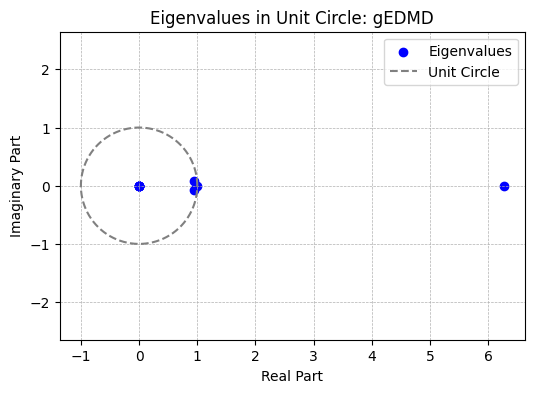

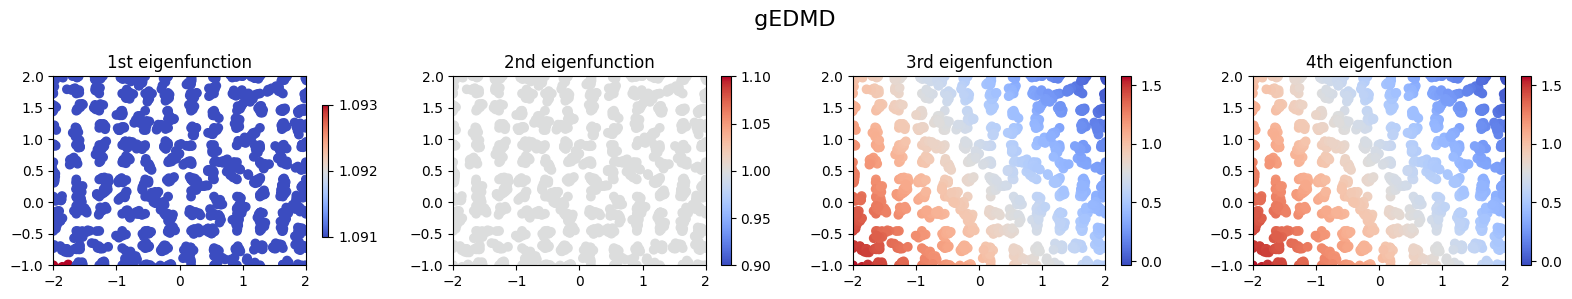

In [13]:
#computing eigenvalues of K from generator eigenvalues using exponetnt
#eigenfunctions are the same for the operator and the generator
evalues= np.exp(evalues)

# Assuming 'efuns' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data
# Assuming evalues is a numpy array of complex numbers

print(evalues.shape)
print(evalues)

# Plot eigenvalues on unit circle
real_parts = evalues.real
imag_parts = evalues.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('Eigenvalues in Unit Circle: gEDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(16, 3))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])
fig.suptitle(' gEDMD ', fontsize=16)
plt.tight_layout()
plt.show()
